In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import PIL
import math
import os
import random
import time

from torch.ao.quantization import QuantStub, DeQuantStub
from tqdm import tqdm
from torchvision import datasets, transforms
from torch.utils.data import Dataset, DataLoader
from PIL import Image

ModuleNotFoundError: No module named 'numpy'

In [2]:
img_path = "./dataset/pkm"
random_img_path = "./dataset/pkm-random"
checkpoint_path = "./checkpoint/image_gen.pth"
# os.remove('./data/images/indeedee-female.png') # corrupted image

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [4]:
def to_pil_image(x):
    return Image.fromarray((x.permute(1, 2, 0).cpu().numpy() * 255).astype(np.uint8))

In [5]:
class SinusoidalEmbedding(nn.Module):
    def __init__(self, time_steps, d_model):
        super().__init__()
        position = torch.arange(time_steps).unsqueeze(1).float()
        div = torch.exp(torch.arange(0, d_model, 2).float() * -(math.log(10000.0) / d_model))
        self.embedding = torch.zeros(time_steps, d_model, requires_grad=False).to(device)
        self.embedding[:, 0::2] = torch.sin(position * div)
        self.embedding[:, 1::2] = torch.cos(position * div)

    def forward(self, x, t):
        return self.embedding[t, None, None, :x.shape[3], None]

In [6]:
class LinearTimeEmbedding(nn.Module):
    def __init__(self, max_time_steps, embedding_dim, d_model):
        super().__init__()
        self.embedding = nn.Embedding(max_time_steps, embedding_dim)
        self.fc1 = nn.Linear(embedding_dim, d_model)
        self.silu = nn.SiLU()
        self.fc2 = nn.Linear(d_model, d_model)

    def forward(self, t):
        x = self.embedding(t)
        x = self.fc1(x)
        x = self.silu(x)
        x = self.fc2(x)
        return x

In [7]:
class ResBlock(nn.Module):
    def __init__(self, in_channels, out_channels, num_groups, time_emb_dim=512, dropout_prob=0.1):
        super().__init__()
        self.time_emb = nn.Linear(time_emb_dim, out_channels)
        self.silu = nn.SiLU()
        self.gnorm1 = nn.GroupNorm(num_groups=num_groups, num_channels=in_channels)
        self.gnorm2 = nn.GroupNorm(num_groups=num_groups, num_channels=out_channels)
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1)
        self.dropout = nn.Dropout(p=dropout_prob, inplace=True)

    def forward(self, x, t_emb):
        x = self.conv1(self.gnorm1(x))
        r = x + self.time_emb(t_emb)[None, :, None, None]
        r = self.dropout(r)
        r = self.conv2(self.silu(self.gnorm2(r)))
        return r + x

In [8]:
class ResBlocks(nn.Module):
    def __init__(self, in_channels, out_channels, num_groups, num_blocks=1, time_emb_dim=512, dropout_prob=0.1):
        super().__init__()
        self.blocks = nn.ModuleList([ResBlock(in_channels, out_channels, num_groups, dropout_prob=dropout_prob, time_emb_dim=time_emb_dim)])
        for _ in range(num_blocks - 1):
            self.blocks.append(ResBlock(out_channels, out_channels, num_groups, dropout_prob=dropout_prob, time_emb_dim=time_emb_dim))

    def forward(self, x, t_emb):
        for m in self.blocks:
            x = m(x, t_emb)
        return x

In [9]:
class AttentionBlock(nn.Module):
    def __init__(self, in_channels, out_channels, num_heads, dropout_prob=0.1):
        super().__init__()
        self.num_heads = num_heads
        self.head_channels = out_channels // num_heads
        assert self.head_channels * self.num_heads == out_channels
        
        self.key = nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1)
        self.query = nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1)
        self.value = nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1)
        self.conv_out = nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1)
        self.dropout = nn.Dropout(p=dropout_prob, inplace=True)
    
    def forward(self, x):
        batch, channels, h, w = x.shape
        query = self.query(x).view(batch, self.num_heads, self.head_channels, h * w)
        key = self.key(x).view(batch, self.num_heads, self.head_channels, h * w).transpose(-1, -2)
        value = self.value(x).view(batch, self.num_heads, self.head_channels, h, w)
        
        score = (query @ key) / (self.head_channels ** 0.5)
        attention = F.softmax(score, dim=-1)
        context = torch.einsum('bhcij,bhcc->bhcij', value, attention).view(batch, self.head_channels * self.num_heads, h, w)
        x = self.dropout(context)
        
        return x

In [10]:
class UNet(nn.Module):
    def __init__(self, num_blocks=2, num_heads=2, num_groups=32, dropout_prob=0.1, num_time_steps=1000, time_emb_dim=512):
        super().__init__()

        self.time_embedding = LinearTimeEmbedding(num_time_steps, 128, time_emb_dim)
        
        self.downconv1 = nn.Conv2d(128, 128, kernel_size=3, stride=2, padding=1)
        self.downconv2 = nn.Conv2d(128, 128, kernel_size=3, stride=2, padding=1)
        self.downconv3 = nn.Conv2d(256, 256, kernel_size=3, stride=2, padding=1)
        self.downconv4 = nn.Conv2d(256, 256, kernel_size=3, stride=2, padding=1)
        self.downconv5 = nn.Conv2d(512, 512, kernel_size=3, stride=2, padding=1)
        
        self.enc1 = ResBlocks(3, 128, 1, dropout_prob=dropout_prob, num_blocks=num_blocks, time_emb_dim=time_emb_dim)
        self.enc2 = ResBlocks(128, 128, num_groups, dropout_prob=dropout_prob, num_blocks=num_blocks, time_emb_dim=time_emb_dim)
        self.enc3 = ResBlocks(128, 256, num_groups, dropout_prob=dropout_prob, num_blocks=num_blocks, time_emb_dim=time_emb_dim)
        self.enc4 = ResBlocks(256, 256, num_groups, dropout_prob=dropout_prob, num_blocks=num_blocks, time_emb_dim=time_emb_dim)
        self.enc5 = ResBlocks(256, 512, num_groups, dropout_prob=dropout_prob, num_blocks=num_blocks, time_emb_dim=time_emb_dim)
        
        self.neck = ResBlocks(512, 512, num_groups, dropout_prob=dropout_prob, num_blocks=num_blocks, time_emb_dim=time_emb_dim)

        self.upconv1 = nn.ConvTranspose2d(512, 512, 2, 2)
        self.upconv2 = nn.ConvTranspose2d(512, 512, 2, 2)
        self.upconv3 = nn.ConvTranspose2d(256, 256, 2, 2)
        self.upconv4 = nn.ConvTranspose2d(256, 256, 2, 2)
        self.upconv5 = nn.ConvTranspose2d(128, 128, 2, 2)

        self.dec1 = ResBlocks(512 + 512, 512, num_groups, dropout_prob=dropout_prob, num_blocks=num_blocks, time_emb_dim=time_emb_dim)
        self.dec2 = ResBlocks(512 + 256, 256, num_heads, dropout_prob=dropout_prob, num_blocks=num_blocks, time_emb_dim=time_emb_dim)
        self.dec3 = ResBlocks(256 + 256, 256, num_heads, dropout_prob=dropout_prob, num_blocks=num_blocks, time_emb_dim=time_emb_dim)
        self.dec4 = ResBlocks(256 + 128, 128, num_groups, dropout_prob=dropout_prob, num_blocks=num_blocks, time_emb_dim=time_emb_dim)
        self.dec5 = ResBlocks(128 + 128, 128, num_groups, dropout_prob=dropout_prob, num_blocks=num_blocks, time_emb_dim=time_emb_dim)

        self.cls_conv = ResBlocks(128, 3, 1, dropout_prob=dropout_prob, num_blocks=num_blocks, time_emb_dim=time_emb_dim)

    def forward(self, x, t):
        t_emb = self.time_embedding(t)
        x = self.enc1(x, t_emb)
        enc1 = x
        x = self.downconv1(enc1)
        x = self.enc2(x, t_emb)
        enc2 = x
        x = self.downconv2(enc2)
        x = self.enc3(x, t_emb)
        enc3 = x
        x = self.downconv3(enc3)
        x = self.enc4(x, t_emb)
        enc4 = x
        x = self.downconv4(enc4)
        x = self.enc5(x, t_emb)
        enc5 = x
        x = self.downconv5(enc5)

        x = self.neck(x, t_emb)

        x = self.upconv1(x)
        x = self.dec1(torch.cat((x, enc5), dim=1), t_emb)
        x = self.upconv2(x)
        x = self.dec2(torch.cat((x, enc4), dim=1), t_emb)
        x = self.upconv3(x)
        x = self.dec3(torch.cat((x, enc3), dim=1), t_emb)
        x = self.upconv4(x)
        x = self.dec4(torch.cat((x, enc2), dim=1), t_emb)
        x = self.upconv5(x)
        x = self.dec5(torch.cat((x, enc1), dim=1), t_emb)

        x = self.cls_conv(x, t_emb)
        return x

In [11]:
class LinearNoiseSchedule():
    def __init__(self, num_time_steps=1000):
        self.beta = torch.linspace(1e-4, 0.02, num_time_steps, requires_grad=False).to(device)
        alpha = 1 - self.beta
        self.alpha = torch.cumprod(alpha, dim=0).requires_grad_(False).to(device)
        self.sqrt_alpha = torch.sqrt(self.alpha).requires_grad_(False).to(device)
        self.sqrt_beta = torch.sqrt(self.beta).requires_grad_(False).to(device)
        self.sqrt_one_minus_beta = torch.sqrt(1 - self.beta).requires_grad_(False).to(device)
        self.sqrt_one_minus_alpha = torch.sqrt(1 - self.alpha).requires_grad_(False).to(device)

In [12]:
class DiffusionModel(nn.Module):
    def __init__(self, unet, noise_schedule):
        super().__init__()
        self.unet = unet
        self.noise_schedule = noise_schedule

    def forward(self, x, t, process='ddim', rand_factor=1.0):
        return self.denoise(x, t, process=process, rand_factor=rand_factor)

    def apply_noise(self, x, timesteps, process='ddpm'):
        if type(timesteps) == int:
            timesteps = torch.IntTensor([timesteps]).requires_grad_(False).to(x.device)
        elif type(timesteps) == tuple or type(timesteps) == list:
            timesteps = torch.IntTensor(timesteps).requires_grad_(False).to(x.device)
        
        noises = torch.randn(timesteps.shape[0], *x.shape).requires_grad_(False).to(x.device)
        x = x * self.noise_schedule.sqrt_alpha[timesteps][:, None, None, None, None] + noises * self.noise_schedule.sqrt_one_minus_alpha[timesteps][:, None, None, None, None]
        return x, noises

    def denoise(self, x, timesteps, process='ddim', rand_factor=1.0)
        if process == 'ddim':
            return self.denoise_ddim(x, timesteps, rand_factor)
        elif process = 'ddpm'
            return self.denoise_ddpm(x, timesteps, rand_factor)
    
    def denoise_ddpm(self, x, timesteps, rand_factor=1.0):
        e_pred = self.model(x, timesteps)
        x0 = x - self.noise_schedule.sqrt_one_minus_alpha[timesteps] * e_pred
        x0 = x0 * self.noise_schedule.sqrt_alpha[timesteps - 1] / self.noise_schedule.sqrt_alpha[timesteps]
        xt_dir = torch.sqrt(self.noise_schedule.alpha[timesteps - 1] - self.noise_schedule.beta[timesteps])
        xt_dir = xt_dir * e_pred
        x = x0 + xt_dir + self.noise_schedule.sqrt_beta[timesteps] * torch.randn_like(x) * rand_factor
        return x

    def denoise_ddim(self, x, t, rand_factor=1.0):
        e_pred = self.unet(x, t)
        x = x - (self.noise_schedule.beta[t]) * e_pred / self.noise_schedule.sqrt_one_minus_alpha[t]
        x = (x / self.noise_schedule.sqrt_one_minus_beta[t]) + self.noise_schedule.sqrt_beta[t] * torch.randn_like(x) * rand_factor
        return x

In [13]:
def generate(sample, end_timestep=1, start_timestep=201, step_gap=10, print_gap=20, denoise_steps=None, noise_step=100):
    if denoise_steps is None:
        denoise_steps = np.arange(end_timestep, start_timestep, step_gap, dtype=np.int32)[::-1].copy()
        denoise_steps = torch.from_numpy(denoise_steps).to(sample.device)
    elif denoise_steps is list:
        denoise_steps = torch.tensor(denoise_steps, dtype=torch.int32).to(sample.device)
    elif denoise_steps is np.array:
        denoise_steps = torch.from_numpy(denoise_steps).to(sample.device)
    
    sample = sample.to(device)
    fig, axs = plt.subplots(1, (start_timestep - end_timestep) // print_gap + 2, figsize=(30, 3))
    axs[0].imshow(to_pil_image(sample[0]))
    axs[0].axis('off')
    
    with torch.no_grad():
        sample = diffusion_model.apply_noise(sample, noise_step)[0][0]
    
    axs[1].imshow(to_pil_image(sample[0]))
    axs[1].axis('off')
    
    model.eval()
    print_idx = 1
    with torch.no_grad():
        for t in denoise_steps:
            sample = diffusion_model.denoise(sample, t)
            if start_timestep - t >= print_gap * print_idx:
                axs[print_idx + 1].imshow(to_pil_image(sample[0]))
                axs[print_idx + 1].axis('off')
                print_idx += 1
    return sample

In [14]:
num_time_steps = 2000

In [15]:
model = UNet(num_time_steps=num_time_steps).to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=3e-4)
criterion = nn.MSELoss()

noise_schedule = LinearNoiseSchedule(num_time_steps=num_time_steps)
diffusion_model = DiffusionModel(model, noise_schedule).to(device)

if os.path.isfile(checkpoint_path):
    checkpoint = torch.load(checkpoint_path, weights_only=False)
    diffusion_model.load_state_dict(checkpoint['diffusion_model'])
    optimizer.load_state_dict(checkpoint['optimizer'])

In [21]:
# import torch
# from diffusers import UNet2DModel

# model = UNet2DModel(
#     sample_size=64,  # the target image resolution
#     in_channels=3,  # the number of input channels, 3 for RGB images
#     out_channels=3,  # the number of output channels
#     layers_per_block=2,  # how many ResNet layers to use per UNet block
#     block_out_channels=(128, 256, 512, 512),  # the number of output channels for each UNet block
#     down_block_types=(
#         "DownBlock2D",
#         "DownBlock2D",
#         "DownBlock2D",
#         "DownBlock2D",
#     ),
#     up_block_types=(
#         "UpBlock2D",  # a regular ResNet upsampling block
#         "UpBlock2D",
#         "UpBlock2D",
#         "UpBlock2D",
#     ),
# ).to(device)
# optimizer = torch.optim.AdamW(model.parameters(), lr=3e-4)

In [26]:
def train(args):
    optimizer.lr = args['lr']
    epoch_per_pbar = args['epoch_per_pbar']
    time_out_sec = args['time_out_sec']
    time_out_epochs = args['time_out_epochs']

    time_out_ep_count = 0
    for ep in range(args['max_training_epochs'] // epoch_per_pbar):
        model.train()
        total_loss = 0
        loss_count = 0
        with tqdm(total=epoch_per_pbar, desc=f'Epoch {ep * epoch_per_pbar + 1}-{(ep + 1) * epoch_per_pbar}/{args['max_training_epochs']}', unit=f'epoch', position=0, leave=True) as pbar_e:
            for pbar_epoch in range(epoch_per_pbar):
                for b, (img, _) in enumerate(dataloader):
                    if args['timesteps'] == None:
                        timesteps = torch.randint(1, num_time_steps, (1,)).to(device)
                    else:
                        timesteps = args['timesteps']
                    img = img.to(device)
                    imgs, noises = diffusion_model.apply_noise(img, timesteps)
                    for noise, im, t in zip(noises, imgs, timesteps):
                        optimizer.zero_grad()
                        e_pred = model(im, t).sample
                        # loss = criterion(e_pred, torch.randn_like(e_pred))
                        loss = criterion(noise, e_pred)
                        loss.backward()
                        optimizer.step()
                        total_loss += loss.item()
                        loss_count += 1
                    pbar_e.set_postfix(loss=total_loss / loss_count)
                pbar_e.update(1)
                time_out_ep_count += 1
                if time_out_ep_count >= time_out_epochs:
                    time_out_ep_count = 0
                    time.sleep(time_out_sec)
                    

In [27]:
args = {}
args['max_training_epochs'] = 500
args['epoch_per_pbar'] = 10
args['lr'] = 1e-6
args['timesteps'] = None
args['time_out_sec'] = 60
args['time_out_epochs'] = 1
args['batch_size'] = 16

In [28]:
transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ColorJitter(brightness=0, contrast=0, saturation=0.2, hue=0.2),
    transforms.ToTensor(),
    transforms.RandomResizedCrop(size=(64, 64), scale=(0.8, 1)),
    transforms.RandomRotation(15, fill=(1,)),
])

dataset = datasets.ImageFolder(root=img_path, transform=transform)
dataloader = DataLoader(dataset, batch_size=args['batch_size'], shuffle=True, pin_memory=True)

random_dataset = datasets.ImageFolder(root=random_img_path, transform=transform)
random_dataloader = DataLoader(random_dataset, batch_size=args['batch_size'], shuffle=True)

In [ ]:
train(args)

In [ ]:
diffusion_model.eval()
sample = dataset[1][0].unsqueeze(0).to(device)
out = generate(sample, noise_step=1500, start_timestep=1991, step_gap=1, print_gap=199)
plt.imshow(to_pil_image(out[0]))
plt.show()

In [ ]:
sample = dataset[50][0].unsqueeze(0).to(device)
generate(sample, noise_step=num_time_step-1, start_timestep=201, step_gap=5, print_gap=20)
plt.show()

In [ ]:
sample = random_dataset[0][0].unsqueeze(0).to(device)
generate(sample, noise_step=num_time_step-1, start_timestep=201, step_gap=10, print_gap=20)
plt.show()

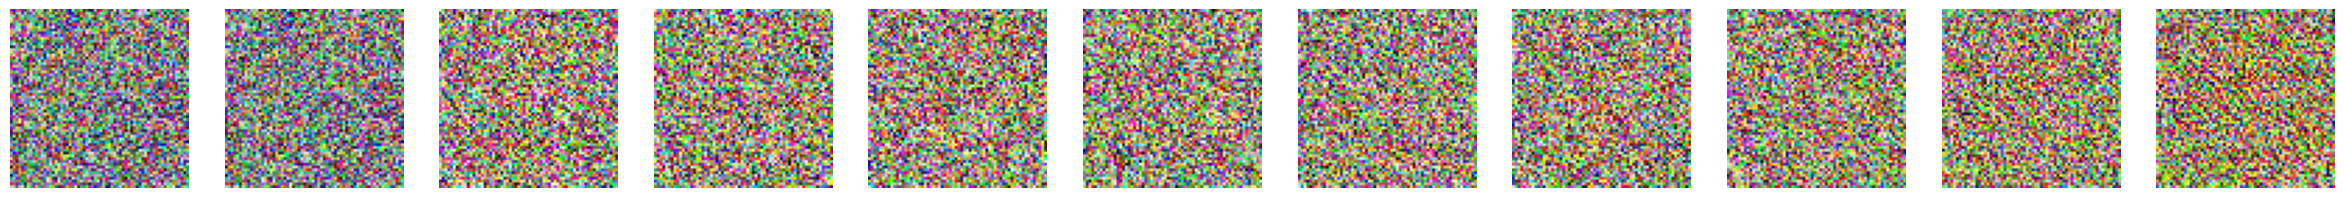

In [32]:
sample = torch.randn(1, 3, 64, 64).to(device)
generate(sample, noise_step=0, start_timestep=1000, step_gap=1, print_gap=100)
plt.show()

In [ ]:
checkpoint = {
    'diffusion_model': diffusion_model.state_dict(),
    'optimizer': optimizer.state_dict(),
}
torch.save(checkpoint, checkpoint_path)